## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import seaborn as sns

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option("max_colwidth", 200)
hypothesis.info()
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


- **Hypothesis** — краткое описание гипотезы;
- **Reach** — охват пользователей по 10-балльной шкале;
- **Impact** — влияние на пользователей по 10-балльной шкале;
- **Confidence** — уверенность в гипотезе по 10-балльной шкале;
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
hypothesis.columns = hypothesis.columns.str.lower() #приведем название колонок к нижнему регистру

In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


- **transactionId** — идентификатор заказа;
- **visitorId** — идентификатор пользователя, совершившего заказ;
- **date** — дата, когда был совершён заказ;
- **revenue** — выручка заказа;
- **group** — группа A/B-теста, в которую попал заказ.

In [5]:
print ('Дубликатов в таблице "orders":', orders.duplicated().sum())

Дубликатов в таблице "orders": 0


In [6]:
orders['date'] = pd.to_datetime(orders['date'])

In [7]:
print('Дата начала тестирования:', orders['date'].min())
print('Дата окончания тестирования:', orders['date'].max())

Дата начала тестирования: 2019-08-01 00:00:00
Дата окончания тестирования: 2019-08-31 00:00:00


In [8]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


- **date** — дата;
- **group** — группа A/B-теста;
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

In [9]:
print ('Дубликатов в таблице: "visitors":', visitors.duplicated().sum())

Дубликатов в таблице: "visitors": 0


In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим кличество пользователей, которые попали в обе грубы А/В-теста:

In [11]:
print(
    'Доля пользователей, попавших в обе группы: {0:.1%}'
    .format(
        len(
            orders.groupby('visitorId')
            .agg({'group': 'nunique'})
            .query('group > 1')
        ) / len(
            orders.groupby('visitorId')
            .agg({'group': 'nunique'})
        )
    )
)
                                                                                                   

Доля пользователей, попавших в обе группы: 5.6%


### Ввод

В работе данные за август 2019 года. Таблицы не содержат дубликатов, но есть незначительное количество пользователей, попавших в обе группы А/В-теста. Изменили тип данных для значений с датами, для удобства переименовали колонки. Предстоит выбрать наиболее удачные гипотезы из девяти преставленных

## Приоритизация гипотез

Применим метод ICE (от англ. impact, confidence, effort) для приоритизации задач:

$$ICE = \frac{Impact * Confidence}{Efforts}$$


In [12]:
pd.set_option("max_colwidth", 200)
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Наиболее перспективные гипотезы по ICE: 8, 0, 7. Сравним с результатом метода RICE (от англ. reach, impact, confidence, effort)

$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$

In [13]:
pd.set_option("max_colwidth", 200)
hypothesis['RICE'] = (
    hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']
) / hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [14]:
cm = sns.light_palette("green", as_cmap=True)

hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False).style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.300000,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.100000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.300000,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


Наиболее перспективные гипотезы по RICE: 2, 0, 7. Седьмая гипотеза поднялась на первое место из-за высокого показателя *Reach*, а восьмая, наоборот, теперь занимает пятую строчку, т.к. охватывает наименьшее количество пользователей

### Вывод

Учитывая результаты применения фреймворков ICE и RICE, можно сделать вывод, что наиболее успешными для увеличения выручки будут 7, 2 и 0 гипотезы

## Анализ A/B-теста

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [16]:
#Получим строки таблицы orders, дата которых меньше или равна дате элемента 
#из datesGroups, а группа теста равна группе из datesGroups
    
#Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум 
#Найдём число уникальных ID заказов и пользователей. 
#Подсчитаем сумму средних чеков
#Применим методы к каждой строке датафрейма: apply(axis=1) и 
#отсортируем результаты по столбцам 'date' и 'group'

ordersAggregated = datesGroups.apply( 
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'transactionId' : 'nunique', 
            'visitorId' : 'nunique', 
            'revenue' : 'sum'
        }
    ), 
    axis=1
).sort_values(by=['date','group'])

ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [17]:
#Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'visitors' : 'sum'
        }
    ), 
    axis=1
).sort_values(by=['date','group'])

visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [18]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


### График кумулятивной выручки по группам

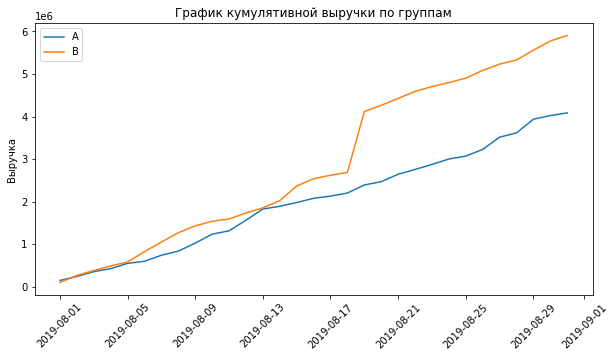

In [21]:
f, ax = plt.subplots(figsize=(10, 5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки по группам')
plt.show()

Выручка обеих групп растет в течение всего теста, однако, выручка группы В выше с самого начала тестирования. 18 августа разница в выручке резко увеличилась и сохранилась до конца тестирования

### График кумулятивного среднего чека по группам

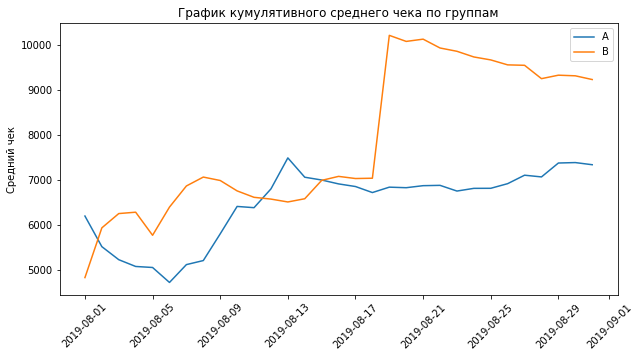

In [22]:
#Построим графики среднего чека по группам — 
#разделим кумулятивную выручку на кумулятивное число заказов

f, ax = plt.subplots(figsize=(10, 5))
plt.plot(
    cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A'
)
plt.plot(
    cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B'
)

plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Средний чек')
plt.title('График кумулятивного среднего чека по группам')
plt.show()

График кумулятивного среднего чека в первой половине месяца неравномерный для обеих групп. Средний чек группы В вырос одновременно с выручкой, а затем стал равномерно снижаться, при этом остался выше среднего чека группы А. 

Построим график относительного различия для среднего чека. 

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)
mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


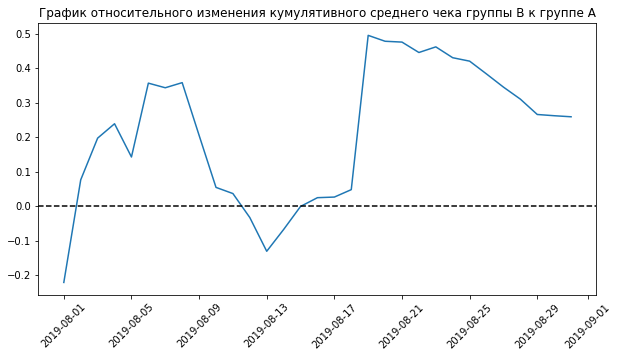

In [24]:
# cтроим отношение средних чеков
f, ax = plt.subplots(figsize=(10, 5))
plt.plot(
    mergedCumulativeRevenue['date'], 
    (
        mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']
    )/(
        mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']
    )-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 


plt.xticks(rotation=45)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

График относительного изменения кумулятивного среднего чека группы B к группе A так же показывает, что, за исключением лишь нескольких дней, средний чек группы В был выше среднего чека группы А и преимущество сохраняется до конца теста

### График кумулятивной конверсии по группам

In [25]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


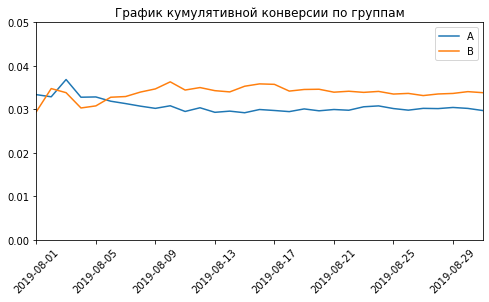

In [26]:
# строим графики

f, ax = plt.subplots(figsize=(8, 4),)

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])
plt.xticks(rotation=45)
plt.title('График кумулятивной конверсии по группам')

plt.show()

Конверсия группы В превысила конверсию группы А со второй недели теста и стабилизировалась до окончания тестирования.

### График относительного изменения кумулятивной конверсии группы B к группе A

In [27]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


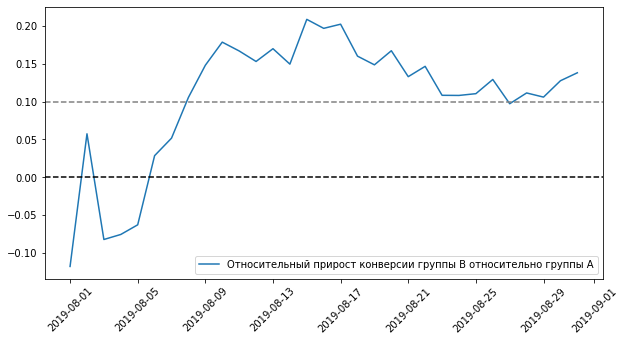

In [28]:
# строим графики

f, ax = plt.subplots(figsize=(10, 5))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= 0.1, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.show()

В начале теста группа B незначительно проигрывала группе A, но с 6 августа отношение конверсии изменилось в большую сторону. 
Проанализируем аномалии, возможно, они изменят картину.

### График количества заказов по пользователям. Определение аномальных заказов.

In [29]:
# Метод .groupby('...', as_index=False) сгруппирует заказы по пользователям
# Метод .agg({'...' : '...',}) посчитает агрегированные метрики на сгруппированных данных
# Метод pd.Series.nunique подсчитает число уникальных заказов

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg( 
        {
            'transactionId': pd.Series.nunique  
        }
    )
)
ordersByUsers.columns = ['visitorId', 'orders']


# Метод .sort_values(by='...',ascending=False) отсортирует датафрейм по значению в столбце
ordersByUsers.sort_values(by='orders', ascending=False).head(10)



,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


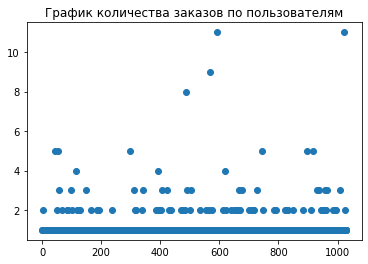

In [30]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')

plt.show()

Пользователи в основном заказывали до двух раз. Посчитаем 95 и 99 перцентили

In [31]:
# Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.

np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

95% пользователей осуществили не более двух заказов, 99% - не более четырех. 

###  График стоимостей заказов. Определение аномальных заказов. 

Проверим распределение выручек

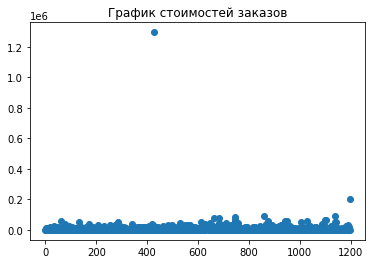

In [32]:
# серия из чисел от 0 до количества заказов

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 
plt.title('График стоимостей заказов')

plt.show()

Стоимость заказов обычно не превышает 100000, но есть и аномальные заказы превышающие 1200000

In [33]:
# Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.

np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

95% пользователей совершили покупки до 28000, а 99% до 58233. Остальные заказы можно считать аномально дорогими. Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей. Затем сравним как изменились показатели без учета аномальных заказов

### Статистическая значимость различий в конверсии между группами по «сырым» данным

In [34]:
orders = orders.rename(columns={"visitorId": "userId", "transactionId": "orderId"})
alpha = 0.05

In [35]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))


        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

- **date** — дата;
- **ordersPerDateA** — количество заказов в выбранную дату в группе A;
- **revenuePerDateA** — суммарная выручка в выбранную дату в группе A;
- **ordersPerDateB** — количество заказов в выбранную дату в группе B;
- **revenuePerDateB** — суммарная выручка в выбранную дату в группе B;
- **ordersCummulativeA** — суммарное число заказов до выбранной даты включительно в группе A;
- **revenueCummulativeA** — суммарная выручка до выбранной даты включительно в группе A;
- **ordersCummulativeB** — суммарное количество заказов до выбранной даты включительно в группе B;
- **revenueCummulativeB** — суммарная выручка до выбранной даты включительно в группе B;
- **visitorsPerDateA** — количество пользователей в выбранную дату в группе A;
- **visitorsPerDateB** — количество пользователей в выбранную дату в группе B;
- **visitorsCummulativeA** — количество пользователей до выбранной даты включительно в группе A;
- **visitorsCummulativeB** — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в конверсии между группами.

In [36]:
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули. 


#Переменная sampleA должна состоять из двух частей:
#Список с количеством заказов для каждого из пользователей: ordersByUsersA['orders'].
#Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и 
#количеством записей о заказах: data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])

sampleA = pd.concat(
    [
        ordersByUsersA['orders'], 
         #Создадим объект pd.Series нужной длины:
        pd.Series(
            0,
            index=np.arange(
                #Список индексов создали функцией np.arange(). Она работает так же, как функция range(), 
                #только создаёт массив индексов в формате np.array, который требуется в pd.Series
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    #передадим аргумент, сообщающий, что объекты Series нужно объединить 
    # по строкам (то есть записать подряд) pd.concat([...], axis=0)
    axis=0,
)

# то же самое сделаем для группы В
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


Применим критерий и отформатируем **p-value**, округлив его до четырех знаков после запятой.

В **sampleA** сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов **sampleA** — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке **sampleA** методом `mean()`. Аналогично найдём конверсию группы B: `SampleB.mean()`.

Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. 

Н0 - Статистически значимых различий в конверсии можду группами нет

Н1 - В конверсии групп А и В есть статистически значимые различия

In [37]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print("P-value: {0:.4f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

if stats.mannwhitneyu(sampleA, sampleB)[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else: print("Не отвергаем нулевую гипотезу") 

print("Относительный прирост конверсии группы В к конверсии группы А: {0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.0168
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы В к конверсии группы А: 13.8%


Анализ "сырых данных" показал, что в конверсии между группами есть статистически значимые различия, а относительный прирост конверсии группы В к конверсии группы А составил 13,8%. 

Сравним средний чек по "сырым данным"

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов.

Н0 - Статистически значимых различий в среднем чеке между группами нет

Н1 - В среднем чеке групп А и В есть статистически значимые различия

In [38]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

if stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else: print("Не отвергаем нулевую гипотезу") 

print('Относительное различие среднего чека между сегментами: {0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Не отвергаем нулевую гипотезу
Относительное различие среднего чека между сегментами: 25.9%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Cредний чек группы B значительно выше среднего чека группы A, что может быть вызвано выбросами.

Проведем анализ данных, очищенных от аномальных значений

###  Статистическая значимость различий в конверсии между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — **usersWithManyOrders** и пользователей, совершивших заказы дороже 30 000 — **usersWithExpensiveOrders**. Объединим их в таблице **abnormalUsers**.
Узнаем, сколько всего аномальных пользователей методом `shape()`.

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: userId, dtype: int64
(68,)


Всего 68 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

Н0 - Статистически значимых различий в конверсии можду группами нет

Н1 - В конверсии групп А и В есть статистически значимые различия

In [40]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)  

#Применим статистический критерий Манна-Уитни к полученным выборкам:

if stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else: print("Не отвергаем нулевую гипотезу") 
    
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительный прирост конверсии группы В к конверсии группы А: {0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Отвергаем нулевую гипотезу
P-value: 0.013
Относительный прирост конверсии группы В к конверсии группы А: 17.2%


В конверсии между группами есть статистически значимые различия, а относительный прирост конверсии группы В к конверсии группы А увеличился до 17,2%. Сравним результаты по среднему чеку

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Н0 - Статистически значимых различий в среднем чеке между группами нет

Н1 - В среднем чеке групп А и В есть статистически значимые различия

In [41]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост конверсии группы В к конверсии группы А: {0:.1%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.720
Относительный прирост конверсии группы В к конверсии группы А: -2.3%


Не отвергаем нулевую гипотезу. Значение p-value практически не изменилось, а относительный прирост конверсии, наоборот, показал противоположный результат

### Вывод

По результатам проведенного анализа, следует  остановить тест и признать его неуспешным. По данным, очищенным от аномальных значений, пользователи из группы В стали покупать чаще, но это не повлияло на средний чек, значит выручка с одной покупки уменьшилась. Нет оснований полагать, что тестируемые изменения увеличат выручку магазина